In [21]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import healpy as hp
import pandas as pd
import scipy
import os
import glob
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7]"

In [3]:
import torch
from torch import nn
#from torchinfo import summary
import torch.optim as optim
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torchvision import datasets, transforms

In [4]:
sys.path.append("./lib")
from cheby_shev import SphericalChebConv
from healpix_pool_unpool import Healpix
from laplacian_funcs import get_healpix_laplacians, patch_laplacian, scipy_csr_to_sparse_tensor
from spherical_unet_utils import SphericalCheb, SphericalChebBN, SphericalChebBNPool
from healpix_pixelshuffle import patch_PSUB, patch_healpix_pixelshuffle
from maploader import MapDataset, get_loaders
from partiallib import get_partial_laplacians, hp_split

In [1]:
from test import simplenetwork, get_params

In [8]:
params = get_params()
train_loader, val_loader = get_loaders(params['hrmaps_dir'], params['lrmaps_dir'], params['n_maps'], 
                                       params['nside_hr'], params['nside_lr'], params['rate_train'], 
                                       params['batch_size'], params['issplit'], params['order'])
model_dir = "./pl-checkpoints"
#model = simplenetwork(params)

#LRsides: 32, HRsides: 64 
#LRpixels: 12288 / 48 = 256
#samples per batch: 192
=> #pixels per batch (input): 49,152
=> #pixels for training (input): 98,304,000
Learning rate will start at 2.0e-04 and reach maximum at 1.0e-03.


In [9]:
model = simplenetwork.load_from_checkpoint(
        "/gpfs02/work/akira.tokiwa/gpgpu/Github/SR-SPHERE-1/a.tokiwa/pl-checkpoints/best.ckpt",
        params=params, strict=False)

In [13]:
dataset_lr = MapDataset(params['lrmaps_dir'], params['n_maps'],  params['nside_lr'], params['issplit'], params['order'])

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [28]:
data_lr = dataset_lr.__getitem__().to(device)

In [30]:
y_hat = model(data_lr[:48])

In [61]:
res = y_hat.detach().cpu().numpy().reshape(-1)

In [62]:
inputs = data_lr[:48].detach().cpu().numpy().reshape(-1)

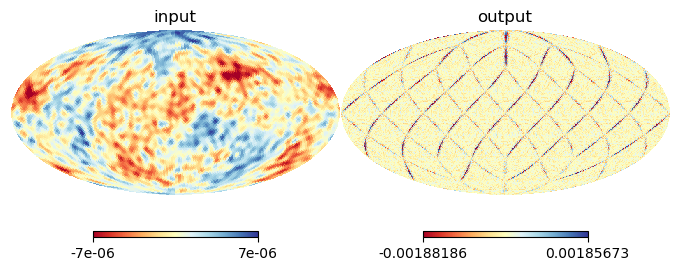

In [67]:
fig = plt.figure(figsize=(10,7))
cm = plt.get_cmap("RdYlBu")
cmin = -7*10e-7#min(np.min(data_test[j]), np.min(truth1[j]), np.min(test1[j]))
cmax = 7*10e-7#max(np.max(data_test[j]), np.max(truth1[j]), np.min(test1[j]))

ax1 = fig.add_axes([0, 0, 0.33, 1])
plt.axes(ax1)
hp.mollview(inputs, cmap="RdYlBu", hold=True, nest=True,  title='input', min=cmin, max=cmax)

ax2 = fig.add_axes([0.33, 0, 0.33, 1])
plt.axes(ax2)
hp.mollview(res, cmap="RdYlBu", hold=True, nest=True,  title='output')

plt.show()